In [1]:
# Sentiment algorithm 3. Sequence of lemmas, sentence number, POS-tag and polarity as multiple features input and binary classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_3'
model_variant = 'w_mask'

training_size = 3000000
test_size = 1000000

In [2]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras import models
import os
import time
import tensorflow as tf
from keras import callbacks
from keras import Input
pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [3]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
3000000 samples are taken from the head for training
1000000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
2999995,404384,cool,cool,ADJ,0.037064,F
2999996,404384,factors,factor,NOUN,-0.055300,F
2999997,404384,like,like,ADP,-0.129606,F
2999998,404384,pore,pore,NOUN,0.000000,F


In [4]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

def gender_seq_to_single(seqs):
    genders = []
    for seq in seqs:
        genders.append(seq[0])
    return genders

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_9768/2965456592.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_9768/2965456592.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
362024,404378,"[Philosophy, Hel...","[philosophy, hel...","[NOUN, VERB, NOUN]","[0.0, -0.2512493...",F
362025,404379,"[Philosophy, gem...","[Philosophy, gem...","[PROPN, NOUN, AD...","[0.0, 0.0, -0.19...",F
362026,404381,"[Benefit, POREfe...","[benefit, porefe...","[VERB, NOUN, NOU...",[-0.167289610994...,F
362027,404383,[Pores],[Pores],[PROPN],[0.0],F


In [5]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,173698,"[plea, agreement...","[plea, agreement...","[NOUN, NOUN, VER...","[0.0, -0.0700639...",M
1,84250,[sleep],[sleep],[VERB],[-0.013157462561...,M
2,226239,"[Care, challenge...","[care, challenge...","[VERB, VERB, NOU...",[-0.058372325330...,M
3,313759,"[emphasized, Fac...","[emphasize, Face...","[VERB, PROPN, VE...","[0.0, 0.0, 0.0, ...",F
4,262401,[Yes],[yes],[INTJ],[0.00566037607667],M
...,...,...,...,...,...,...
362024,318703,"[personal, vote,...","[personal, vote,...","[ADJ, NOUN, VERB...",[-0.103934611628...,M
362025,402869,"[preparing, pote...","[prepare, potent...","[VERB, ADJ, NOUN...",[-0.033498262125...,F
362026,275587,"[defensive, ends...","[defensive, end,...","[ADJ, VERB, VERB...",[-0.035786579228...,M
362027,386285,"[girls, deserve,...","[girl, deserve, ...","[NOUN, VERB, ADJ]",[0.1955744783548...,F


<AxesSubplot:>

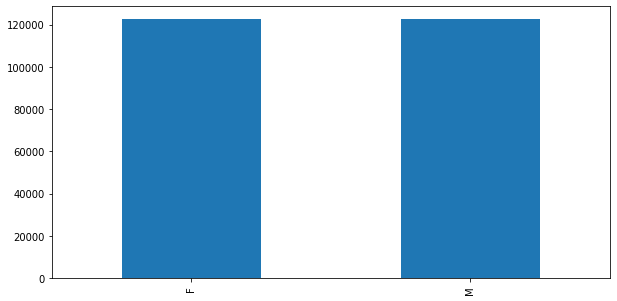

In [6]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
def equal_genders(data_):
    M, F = data_["Gender"].value_counts()
    if M>F:
        diff = M-F
        return data_.drop(data_.loc[data_['Gender'] == 'M'].index[:diff], axis=0)
    elif F>M:
        diff = F-M
        return data_.drop(data_.loc[data_['Gender'] == 'F'].index[:diff], axis=0)

train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

In [7]:
# DEFINE FUNCTION FOR PLOTTING SENTENCE LENGTHS
def plot_sentence_lengths(data_):
    sentence_plot = data_["Word"].values
    sentence_plot_sorted = list(sorted(sentence_plot, key=len))
    c = Counter(map(len, sentence_plot_sorted))

    total_sentences = 0
    total_words = 0
    for i in c:
        total_sentences = total_sentences + c[i]
        total_words = total_words + c[i]*i

    sentences_80_pct = total_sentences / 100 * 90
    words_80_pct = total_words / 100 * 90

    boundary_sen = 0
    counter_sen = 0

    for i in c:
        if(counter_sen + c[i] < int(sentences_80_pct)):
            counter_sen = counter_sen + c[i]
            boundary_sen = i
        else:
            break

    boundary_word = 0
    counter_word = 0

    for i in c:
        if(counter_word + c[i] * i < int(words_80_pct)):
            counter_word = counter_word + c[i] * i
            boundary_word = i
        else:
            break


    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


    plt.figure(figsize=[10,6])
    bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

    # for r in bars.get_children():
    #     if(r.get_x() > boundary_sen):
    #         r.set_alpha(0.2)

    plt.legend(loc="best")
    plt.ylim([0, max(list(c.values()))+10])
    ax2 = plt.gca()

    ymin, ymax = ax2.get_ylim()
    plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
    # plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

    plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
    plt.legend()
    plt.show()
    return boundary_sen

No handles with labels found to put in legend.


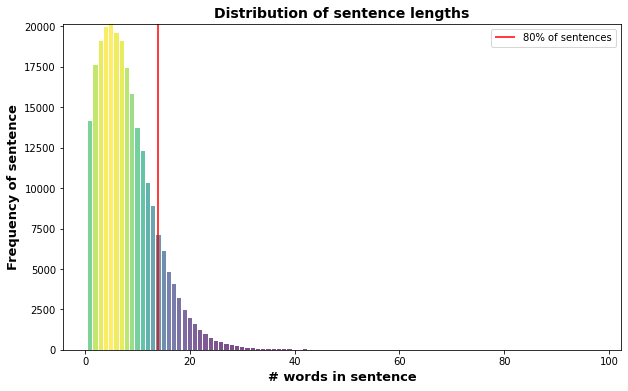

Decision boundary / 80 pct of sentence lengths is: 14


In [8]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [9]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
def encode_feature(train_data_, test_data_):
    tokenizer = Tokenizer()
    # ONLY FIT ON TRAIN DATA
    tokenizer.fit_on_texts(train_data_)
    return tokenizer.texts_to_sequences(train_data_), tokenizer.texts_to_sequences(test_data_), len(tokenizer.word_index)

train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size_lemma = encode_feature(train_data['Lemma'], test_data['Lemma'])
train_data['POS_enc'], test_data['POS_enc'], vocab_size_pos = encode_feature(train_data['POS'], test_data['POS'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train_lemma = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_train_pos = pad_sequences(train_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

X_test_lemma = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test_pos = pad_sequences(test_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [10]:
# ONE-HOT TARGET (GENDER)
le = LabelEncoder()
le.classes_ = ['M', 'F']

y_train = le.transform(train_data['Gender'])
y_test = le.transform(test_data['Gender'])

y_train = to_categorical(y_train)

print('[M] =', le.transform(['M']), '=', to_categorical(le.transform(['M']),2))
print('[F] =', le.transform(['F']), '=', to_categorical(le.transform(['F']),2))

[M] = [0] = [[1. 0.]]
[F] = [1] = [[0. 1.]]


In [11]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

my_callbacks = [earlystopping, tensorboard_cb]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lemma_input (InputLayer)        [(None, 14)]         0                                            
__________________________________________________________________________________________________
POS_input (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
lemma_embedding (Embedding)     (None, 14, 128)      5350784     lemma_input[0][0]                
__________________________________________________________________________________________________
POS_embedding (Embedding)       (None, 14, 128)      2304        POS_input[0][0]                  
______________________________________________________________________________________________

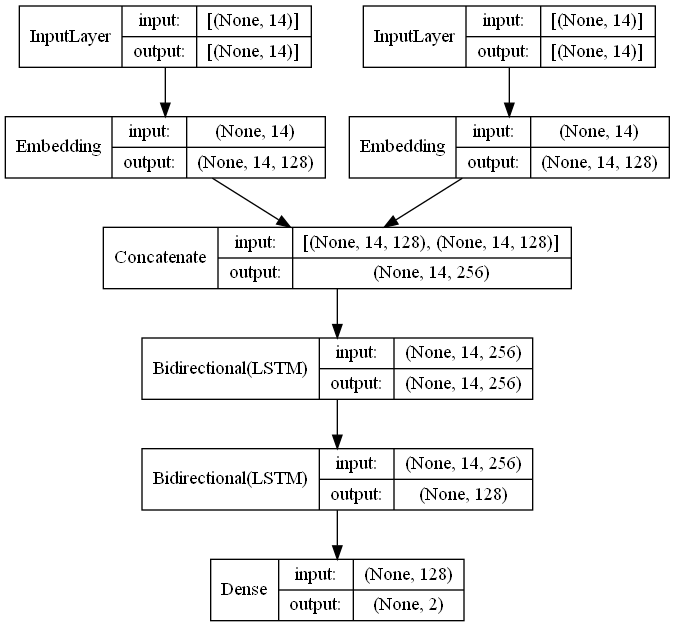

In [12]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

lemma_input = Input(shape=(max_len), name='lemma_input')
pos_input = Input(shape=(max_len), name='POS_input')

lemma_embedding = layers.Embedding(vocab_size_lemma+1, embedding_dim, input_length=max_len, name="lemma_embedding", mask_zero=True)(lemma_input)
pos_embedding = layers.Embedding(vocab_size_pos+1, embedding_dim, input_length=max_len, name="POS_embedding")(pos_input)

concat = layers.Concatenate()([lemma_embedding, pos_embedding])

bidir_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(concat)

bidir_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))(bidir_1)

output = layers.Dense(2, activation="softmax", name='output')(bidir_2)

model = keras.Model(inputs=[lemma_input, pos_input], outputs=[output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [13]:
# FITTING MODEL

history = model.fit([X_train_lemma, X_train_pos], y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)


Epoch 1/20
6126/6126 [==============================] - 2374s 383ms/step - loss: 0.4695 - accuracy: 0.7717 - val_loss: 0.4609 - val_accuracy: 0.7682
Epoch 2/20
6126/6126 [==============================] - 2499s 408ms/step - loss: 0.4038 - accuracy: 0.8099 - val_loss: 0.4563 - val_accuracy: 0.7712
Epoch 3/20
6126/6126 [==============================] - 2563s 418ms/step - loss: 0.3592 - accuracy: 0.8325 - val_loss: 0.4696 - val_accuracy: 0.7636
Epoch 4/20
6126/6126 [==============================] - 2507s 409ms/step - loss: 0.3199 - accuracy: 0.8519 - val_loss: 0.4887 - val_accuracy: 0.7650
Epoch 5/20
6126/6126 [==============================] - 2516s 411ms/step - loss: 0.2834 - accuracy: 0.8687 - val_loss: 0.5387 - val_accuracy: 0.7636
Epoch 6/20
6126/6126 [==============================] - 2287s 373ms/step - loss: 0.2520 - accuracy: 0.8837 - val_loss: 0.6286 - val_accuracy: 0.7503
Epoch 7/20
6126/6126 [==============================] - 1935s 316ms/step - loss: 0.2270 - accuracy: 0.8946

red is training, blue is validation


<Figure size 432x288 with 0 Axes>

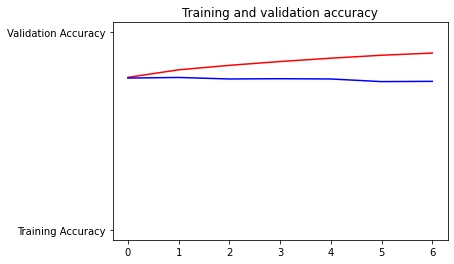

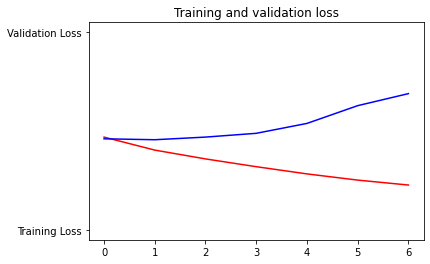

<Figure size 432x288 with 0 Axes>

In [14]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [15]:
# PREDICT TEST DATA
y_pred = model.predict([X_test_lemma, X_test_pos])
y_pred = y_pred.argmax(axis=-1)
y_pred = y_pred.flatten()
y_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [16]:
# SAVING MODEL
model.save('saved_models/' + model_name + '/' + model_variant + '.h5')

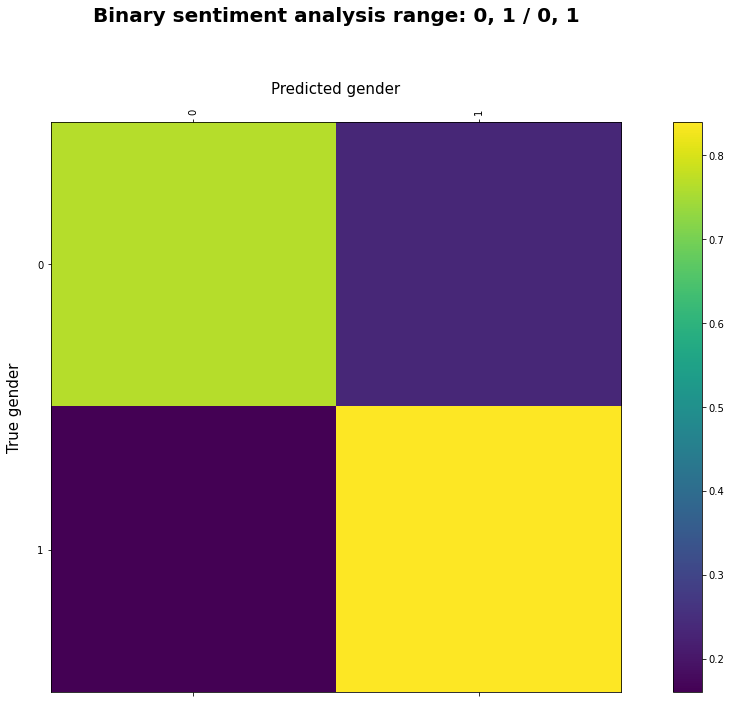

In [17]:
# PLOTTING CONFUSION MATRIX
y_test = np.array(y_test).flatten()
cm = confusion_matrix(y_test, y_pred, normalize='true')

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted gender', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True gender', fontsize = 15, labelpad=15.0)
ax.set_title('Binary sentiment analysis range: 0, 1 / 0, 1',fontweight="bold", size=20, pad=100.0)

cm_axis_vals = []

for x in np.unique(np.array(y_pred)):
    cm_axis_vals.append(x)

fig.colorbar(cax)
plt.xticks(range(2), cm_axis_vals, rotation=90)
plt.yticks(range(2), cm_axis_vals)
plt.show()

In [18]:
# PRINTING METRICS
from sklearn.metrics import classification_report
sentiment_vocab = ['M', 'F']

report = classification_report(y_test, y_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\hanse\AppData\Local\Temp/ipykernel_9768/914610997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.72,0.76,0.74,36112.0
1,F,0.87,0.84,0.85,67446.0
